In [1]:
import sys
sys.path.append('../../../reference-matching-evaluation')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import utils.data_format_keys as dfk

from evaluation.link_metrics import LinkMetricsResults
from evaluation.reference_metrics import ReferenceMetricsResults
from utils.utils import read_json, save_json

In [2]:
data_dir = 'data/'
img_dir = 'images/'

In [3]:
summary = read_json(data_dir + 'summary.json')
summary[900]

{'source_DOI': '10.3758/bf03335347',
 'reference': {'key': 'BF03335347_CR10',
  'doi-asserted-by': 'crossref',
  'first-page': '129',
  'DOI': '10.1677/joe.0.0440129',
  'volume': '44',
  'author': 'J M Davidson',
  'year': '1969',
  'unstructured': 'Davidson, J. M., & Levine, S. Progesterone and hetero-typical sexual behaviour in male rats. Journal of Endocrinology, 1969, 44, 129–130.',
  'journal-title': 'Journal of Endocrinology',
  'source_DOI': '10.3758/bf03335347'},
 'publisher_link': None,
 'open_url': '10.1677/joe.0.0440129',
 'sbmv_structured': {'DOI': '10.1677/joe.0.0440129', 'score': 1.0},
 'simple_text_query': '10.1677/joe.0.0440129',
 'sbmv_unstructured': {'DOI': '10.1677/joe.0.0440129',
  'score': 0.7952720877737227},
 'gt': '10.1677/joe.0.0440129'}

In [4]:
def category(item):
    if item['publisher_link'] is not None:
        return 'publisher'
    if 'c' in item:
        return 'error'
    if 'unstructured' in item['reference'] and ('year' in item['reference'] or 'author' in item['reference']):
        return 'both'
    if 'unstructured' in item['reference']:
        return 'unstructured'
    if 'year' in item['reference'] or 'author' in item['reference']:
        return 'structured'
    return 'other'

In [5]:
categories = [category(s) for s in summary]
categories = {cat: categories.count(cat) for cat in set(categories)}
categories

{'unstructured': 174,
 'error': 49,
 'structured': 862,
 'both': 375,
 'publisher': 540}

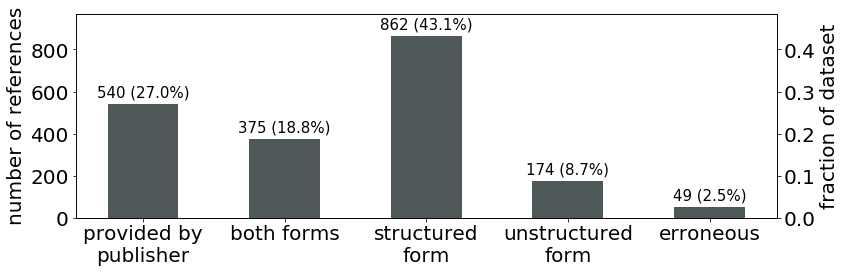

In [19]:
categorie = [categories['publisher'], categories['both'], categories['structured'], categories['unstructured'],
              categories['error']]
ind = np.arange(len(categories))
width = 0.5
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 15}) 
fig, ax = plt.subplots(figsize=(12, 4))

rects1 = ax.bar(ind+0.5*width, categorie, width=width, color='#4f5858')
ax.set_ylabel('number of references')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('provided by\npublisher', 'both forms', 'structured\nform', 'unstructured\nform', 'erroneous'))
plt.ylim(0, 970)

ax2 = ax.twinx()
ax2.set_ylabel('fraction of dataset')
ax2.set_ylim(0, 970/2000)
ax2.set_yticks((0, 0.1, 0.2, 0.3, 0.4))
plt.rcParams.update({'font.size': 15})
for rect in rects1:
    height = rect.get_height()
    text = '{} ({:.1f}%)'.format(height, 100*height/2000)
    ax.text(rect.get_x() + rect.get_width()/2., height+20, text, ha='center', va='bottom')

fig.tight_layout()

plt.savefig(img_dir + 'data_distr.png', dpi=300, bbox_inches='tight')

In [7]:
def build(summary, test_fun, score_fun=None):
    return [{'reference': s['reference'],
         'target_gt': {'DOI': s['gt']},
         'target_test': {'DOI': test_fun(s)},
         'score': None if score_fun is None else score_fun(s)} for s in summary]

def get_results(data):
    results_link = LinkMetricsResults(data)
    results_ref = ReferenceMetricsResults(data)
    return results_link.get(dfk.EVAL_PREC), results_link.get(dfk.EVAL_REC), results_link.get(dfk.EVAL_F1), \
                  results_ref.get(dfk.EVAL_ACCURACY)

def print_results(data, name):
    results_link = LinkMetricsResults(data)
    results_ref = ReferenceMetricsResults(data)
    print('{} (size {})'.format(name, len(data)))
    print('  precision {:.4f}, recall {:.4f}, f1 {:.4f}, accuracy {:.4f}'
          .format(results_link.get(dfk.EVAL_PREC), results_link.get(dfk.EVAL_REC), results_link.get(dfk.EVAL_F1),
                  results_ref.get(dfk.EVAL_ACCURACY)))

In [8]:
def get_legacy(ref):
    if ref['publisher_link'] is not None:
        return ref['publisher_link']
    return ref['open_url'] if ref['open_url'] is not None else ref['simple_text_query']

def get_sbmv_unstr(item):
    if item.get('sbmv_unstructured') is not None and item.get('sbmv_unstructured').get('score') is not None \
            and item.get('sbmv_unstructured').get('score') >= 0.34:
        return item.get('sbmv_unstructured').get('DOI')
    return None

def get_sbmv_str(item):
    if item.get('sbmv_structured') is not None and item.get('sbmv_structured').get('score') is not None \
            and item.get('sbmv_structured').get('score') >= 0.76:
        return item.get('sbmv_structured').get('DOI')
    return None

def get_sbmv(ref):
    if ref['publisher_link'] is not None:
        return ref['publisher_link']
    unstr = get_sbmv_unstr(ref)
    if unstr is not None:
        return unstr
    return get_sbmv_str(ref)

In [9]:
publisher_only = [s for s in summary if category(s) == 'publisher']
data_publisher = build(publisher_only, lambda s: s['publisher_link'])
print_results(data_publisher, 'Publisher')

Publisher (size 540)
  precision 0.9907, recall 0.9907, f1 0.9907, accuracy 0.9907


In [10]:
unstructured_only = [s for s in summary if category(s) in ['unstructured', 'both']]
data_unstructured_legacy = build(unstructured_only, lambda s: s['simple_text_query'])
print_results(data_unstructured_legacy, 'STQ')

STQ (size 549)
  precision 0.9965, recall 0.8663, f1 0.9268, accuracy 0.9180


In [11]:
unstructured_only = [s for s in summary if category(s) in ['unstructured', 'both']]
data_unstructured_new = build(unstructured_only, get_sbmv_unstr)
print_results(data_unstructured_new, 'SBMV unstructured')

SBMV unstructured (size 549)
  precision 0.9812, recall 0.9544, f1 0.9676, accuracy 0.9636


In [12]:
structured_only = [s for s in summary if category(s) in ['structured', 'both']]
data_structured_legac y = build(structured_only, lambda s: s['open_url'])
print_results(data_structured_legacy, 'Open URL')

Open URL (size 1237)
  precision 0.9899, recall 0.9213, f1 0.9544, accuracy 0.9394


In [13]:
structured_only = [s for s in summary if category(s) in ['structured', 'both']]
data_structured_new = build(structured_only, get_sbmv_str)
print_results(data_structured_new, 'SBMV structured')

SBMV structured (size 1237)
  precision 0.9720, recall 0.9389, f1 0.9552, accuracy 0.9466


In [14]:
data_legacy = build(summary, get_legacy)
print_results(data_legacy, 'Legacy')

Legacy (size 2000)
  precision 0.9891, recall 0.9446, f1 0.9664, accuracy 0.9550


In [15]:
data_new = build(summary, get_sbmv)
print_results(data_new, 'new')

new (size 2000)
  precision 0.9769, recall 0.9668, f1 0.9718, accuracy 0.9655


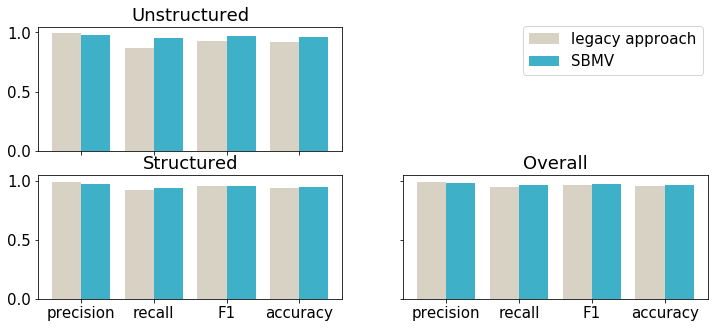

In [16]:
plt.rcParams.update({'font.size': 15, 'legend.fontsize': 15})
f, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 5))
ind = np.arange(4)
width = 0.4

rects1 = axes[0,0].bar(ind, get_results(data_unstructured_legacy), width=width, color="#d8d2c4")
rects2 = axes[0,0].bar(ind+width, get_results(data_unstructured_new), width=width, color="#3eb1c8")
axes[0,0].set_title('Unstructured')
rects1 = axes[1,0].bar(ind, get_results(data_structured_legacy), width=width, color="#d8d2c4")
rects2 = axes[1,0].bar(ind+width, get_results(data_structured_new), width=width, color="#3eb1c8")
axes[1,0].set_title('Structured')
rects1 = axes[1,1].bar(ind, get_results(data_legacy), width=width, color="#d8d2c4")
rects2 = axes[1,1].bar(ind+width, get_results(data_new), width=width, color="#3eb1c8")
axes[1,1].set_title('Overall')
axes[0,0].set_xticks(ind + width / 2)
axes[0,0].set_xticklabels(('precision', 'recall', 'F1', 'accuracy'))
axes[0,1].axis('off')
axes[0,0].legend((rects1[0], rects2[0]), ('legacy approach', 'SBMV'),
                  loc=3, bbox_to_anchor=(1.57, 0.55))
plt.savefig(img_dir + 'results.png', dpi=300, bbox_inches='tight')